# Transformada de Fourier 1D

Este IPython Notebook reproduz os exemplos apresentados por Jake Vanderplas em seu [blog](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/).

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams as rc
from scipy.fftpack import fft, ifft, fftfreq, fftshift, rfft, irfft

In [3]:
rc['lines.linewidth'] = 1.
rc['font.size'] = 14

### Funções para calcular a Transformada de Fourier 1D

In [4]:
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x. This 
    function was originally presented by Jake Vanderplas on his blog 
    (https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)."""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

def iDFT_slow(x):
    """Compute the inverse discrete Fourier Transform of the 1D 
    array x."""
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(2j * np.pi * k * n / N)
    M /= N
    return np.dot(M, x)

def FFT_recursive(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT. This 
    function was originally presented by Jake Vanderplas on his blog 
    (https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)."""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT_slow(x)
    else:
        X_even = FFT_recursive(x[::2])
        X_odd = FFT_recursive(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N / 2] * X_odd,
                               X_even + factor[N / 2:] * X_odd])

def FFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT. This 
    function was originally presented by Jake Vanderplas on his blog 
    (https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)."""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] / 2]
        X_odd = X[:, X.shape[1] / 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

### Exemplo de Transformada de Fourier 1D

Este exemplo foi retirado da [documentação do Scipy](http://docs.scipy.org/doc/scipy-dev/reference/tutorial/fftpack.html).

In [5]:
# Número de amostras
N = 2**8
# Intervalo de amostragem
T = 1.0 / 800.0
# Coordenadas do sinal
x = np.linspace(0.0, N*T, N)

$y = \text{sen}(50 \; 2\pi \; x) + 0,5 \, \text{sen}(80 \; 2\pi \; x)$

In [6]:
y1 = np.sin(50.0 * 2.0*np.pi*x) 
y2 = 1.5*np.sin(100.0 * 2.0*np.pi*x)
y = y1 + y2

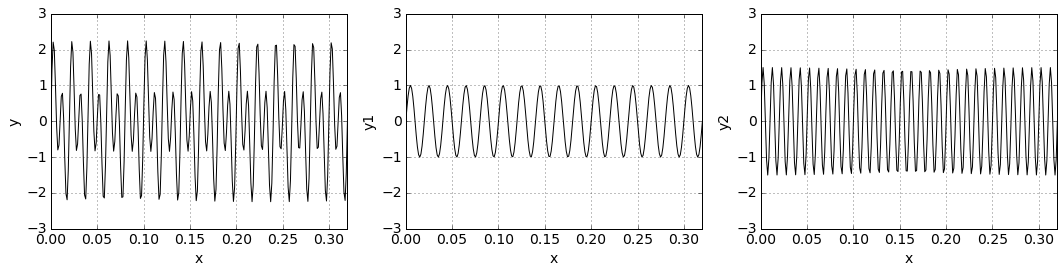

In [7]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(x, y, 'k-')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x.min(), x.max())
plt.ylim(-3, 3)

plt.subplot(1,3,2)
plt.plot(x, y1, 'k-')
plt.grid()
plt.xlabel('x')
plt.ylabel('y1')
plt.xlim(x.min(), x.max())
plt.ylim(-3, 3)

plt.subplot(1,3,3)
plt.plot(x, y2, 'k-')
plt.grid()
plt.xlabel('x')
plt.ylabel('y2')
plt.xlim(x.min(), x.max())
plt.ylim(-3, 3)

plt.tight_layout()

plt.show()

In [8]:
# Transformada de Fourier 1D
Y = fft(y) # Scipy
Y_slow = DFT_slow(y) # Slow
Y_recursive = FFT_recursive(y) # Recursive
Y_vectorized = FFT_vectorized(y) # Vectorized

In [9]:
# Espectro de amplitude
Y_amp = 2.0/N * np.abs(Y)
Y_slow_amp = 2.0/N * np.abs(Y_slow)
Y_recursive_amp = 2.0/N * np.abs(Y_recursive)
Y_vectorized_amp = 2.0/N * np.abs(Y_vectorized)

In [10]:
# Frequência crítica de Nyquist
fn = 1./(2.*T)
# Frequências da primeira metade do espectro
f = fftfreq(N, T)

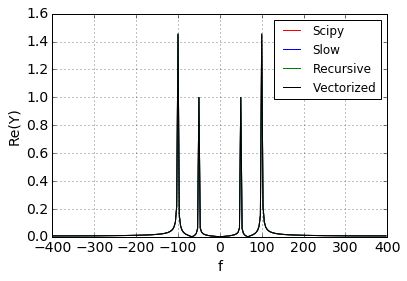

In [11]:
plt.figure()
plt.plot(fftshift(f), fftshift(np.real(Y_amp)), 'r-', label='Scipy')
plt.plot(fftshift(f), fftshift(np.real(Y_slow_amp)), 'b-', label='Slow')
plt.plot(fftshift(f), fftshift(np.real(Y_recursive_amp)), 'g-', label='Recursive')
plt.plot(fftshift(f), fftshift(np.real(Y_vectorized_amp)), 'k-', label='Vectorized')
plt.grid()
plt.xlabel('f')
plt.ylabel('Re(Y)')
plt.legend(loc='best', fontsize=12)
plt.show()

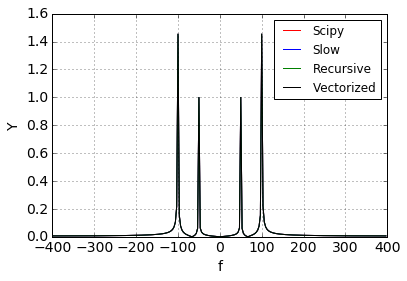

In [12]:
plt.figure()
plt.plot(fftshift(f), fftshift(Y_amp), 'r-', label='Scipy')
plt.plot(fftshift(f), fftshift(Y_slow_amp), 'b-', label='Slow')
plt.plot(fftshift(f), fftshift(Y_recursive_amp), 'g-', label='Recursive')
plt.plot(fftshift(f), fftshift(Y_vectorized_amp), 'k-', label='Vectorized')
plt.grid()
plt.xlabel('f')
plt.ylabel('Y')
plt.legend(loc='best', fontsize=12)
plt.show()

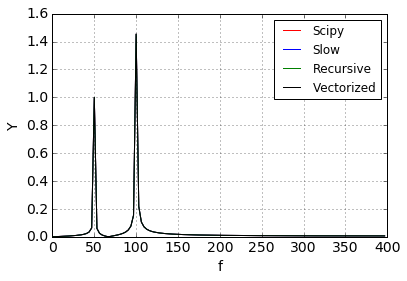

In [13]:
plt.figure()
plt.plot(f[:N/2], Y_amp[:N/2], 'r-', label='Scipy')
plt.plot(f[:N/2], Y_slow_amp[:N/2], 'b-', label='Slow')
plt.plot(f[:N/2], Y_recursive_amp[:N/2], 'g-', label='Recursive')
plt.plot(f[:N/2], Y_vectorized_amp[:N/2], 'k-', label='Vectorized')
plt.grid()
plt.xlabel('f')
plt.ylabel('Y')
plt.legend(loc='best', fontsize=12)
plt.show()

### Exemplo de Transformada Inversa de Fourier 1D

In [14]:
# Transformada de Fourier 1D
y_estimado = ifft(Y) # Scipy

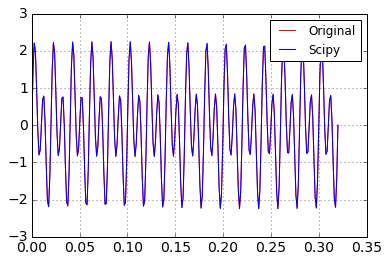

In [15]:
plt.figure()
plt.plot(x, y, 'r-', label='Original')
plt.plot(x, y_estimado.real, 'b-', label='Scipy')
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.show()

### Exemplo de Transformada de Fourier 1D 2

Este exemplo foi retirado do livro do Brigham (1988), example 2.1, p. 10.

* Brigham, E. O., 1988, The Fast Fourier Transform and its applications, Prentice Hall, New Jersey, ISBN 0-13-307505-2 


**Resultados analíticos**

In [16]:
# Número de amostras
N = 2**11

# Fator de normalização
norm = 1./np.sqrt(N)

# limite inferior e superior da variável y
ymin = 0.0
ymax = 40.0

# Intervalo de amostragem
T = (ymax - ymin)/(N-1)

In [17]:
# Frequência crítica de Nyquist
fn = 1./(2.*T)
# Frequências da primeira metade do espectro
f = fftfreq(N, T)

In [18]:
print 'N = %d' % N
print 'fn = %10.5f' % fn
print 'fmin = %10.5f | fmax = %10.5f' % (np.min(f), np.max(f))

N = 2048
fn =   25.58750
fmin =  -25.58750 | fmax =   25.56251


In [19]:
y = np.linspace(ymin, ymax, N)

alfa = 1.0
beta = 1.0

g = beta*np.exp(-alfa*y)

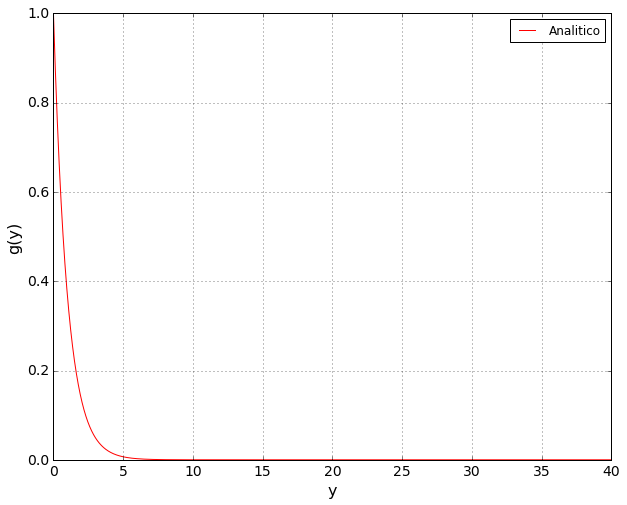

In [20]:
plt.figure(figsize=(10,8))
plt.plot(y, g, 'r-', label='Analitico')
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.xlabel('y', fontsize=16)
plt.ylabel('g(y)', fontsize=16)
plt.show()

In [21]:
ReG = alfa*beta/(alfa**2 + (2.*np.pi*f)**2)
ImG = -2.*np.pi*f*beta/(alfa**2 + (2.*np.pi*f)**2)
G = ReG + (0.+1.j)*ImG
AmpG = np.abs(G)
#F = np.arctan2(ImG,ReG)
#F = np.arctan2(-2.*np.pi*f,alfa)
F = np.angle(G)

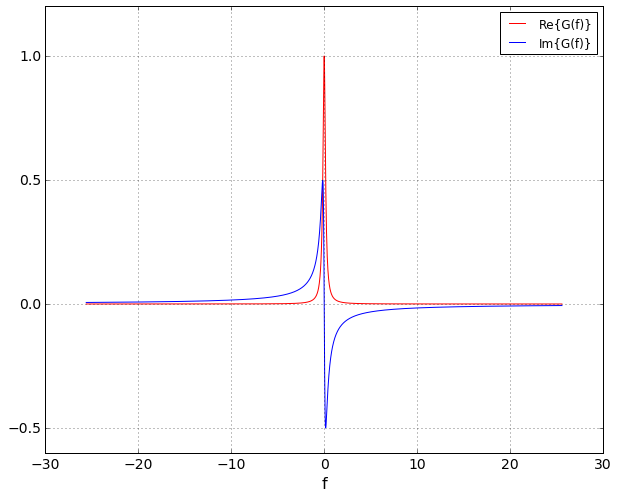

In [22]:
plt.figure(figsize=(10,8))
plt.plot(fftshift(f), fftshift(ReG), 'r-', label='Re{G(f)}')
plt.plot(fftshift(f), fftshift(ImG), 'b-', label='Im{G(f)}')
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.xlabel('f', fontsize=16)
plt.show()

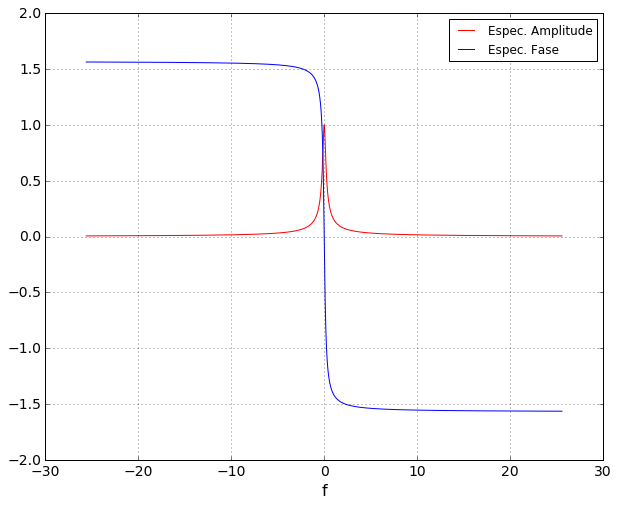

In [23]:
plt.figure(figsize=(10,8))
plt.plot(fftshift(f), fftshift(AmpG), 'r-', label='Espec. Amplitude')
plt.plot(fftshift(f), fftshift(F), 'b-', label='Espec. Fase')
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.xlabel('f', fontsize=16)
plt.show()

In [24]:
G_Scipy = fft(g)
#G_Scipy = rfft(g)

In [25]:
ReG_Scipy = np.real(G_Scipy)
ImG_Scipy = np.imag(G_Scipy)
AmpG_Scipy = np.abs(G_Scipy)
#F_Scipy = np.arctan2(ImG_Scipy,ReG_Scipy)
F_Scipy = np.angle(G_Scipy)

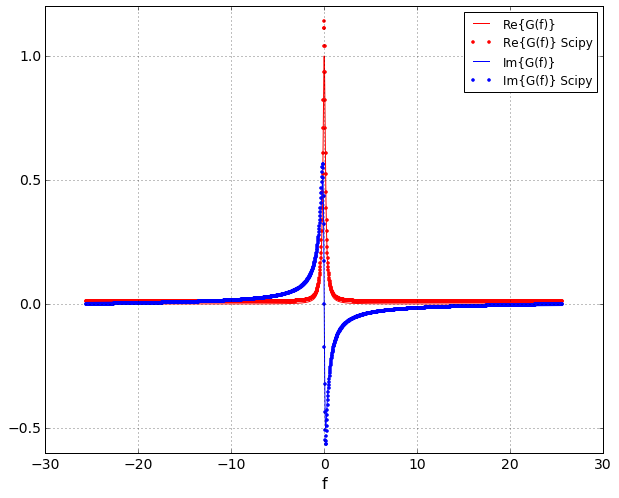

In [26]:
plt.figure(figsize=(10,8))
plt.plot(fftshift(f), fftshift(ReG), 'r-', label='Re{G(f)}')
plt.plot(fftshift(f), norm*fftshift(ReG_Scipy), 'r.', label='Re{G(f)} Scipy')
plt.plot(fftshift(f), fftshift(ImG), 'b-', label='Im{G(f)}')
plt.plot(fftshift(f), norm*fftshift(ImG_Scipy), 'b.', label='Im{G(f)} Scipy')
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.xlabel('f', fontsize=16)
plt.show()

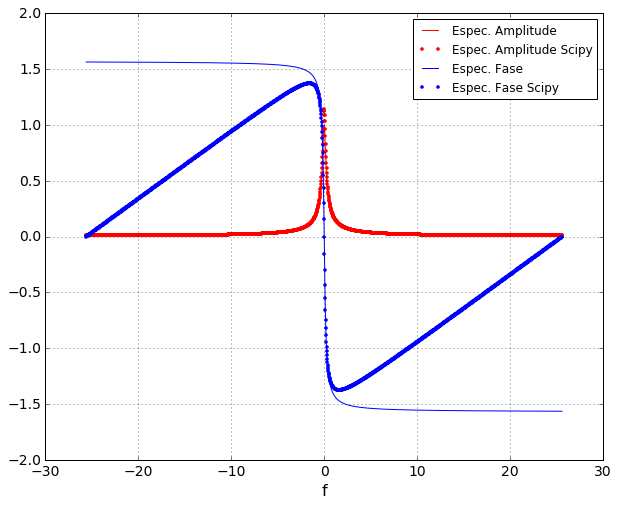

In [27]:
plt.figure(figsize=(10,8))
plt.plot(fftshift(f), fftshift(AmpG), 'r-', label='Espec. Amplitude')
plt.plot(fftshift(f), norm*fftshift(AmpG_Scipy), 'r.', label='Espec. Amplitude Scipy')
plt.plot(fftshift(f), fftshift(F), 'b-', label='Espec. Fase')
plt.plot(fftshift(f), fftshift(F_Scipy), 'b.', label='Espec. Fase Scipy')
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.xlabel('f', fontsize=16)
plt.show()

In [28]:
g_Scipy = ifft(G_Scipy)

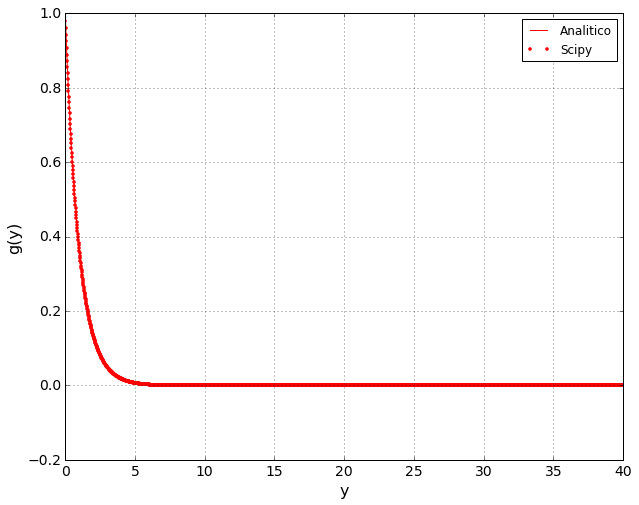

In [29]:
plt.figure(figsize=(10,8))
plt.plot(y, g, 'r-', label='Analitico')
plt.plot(y, g_Scipy.real, 'r.', label='Scipy')
plt.grid()
plt.legend(loc='best', fontsize=12)
plt.xlabel('y', fontsize=16)
plt.ylabel('g(y)', fontsize=16)
plt.show()